In [1]:
# Librerías
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Normalización
from sklearn.preprocessing import StandardScaler

# Machine Learning
import torch
import torch.nn as nn
from torch.optim import AdamW


In [2]:
# Clase para predecir un valor escalar a partir de una secuencia de datos de entrada. 

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, seq_length):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.d_model = d_model
        self.dropout = dropout
        
        # Embedding lineal para transformar la entrada a un tamaño d_model
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Capa de Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Capa fully connected para la salida de un valor escalar
        self.fc = nn.Linear(d_model, 1)
        
        # Embedding posicional
        self._create_positional_embeddings(seq_length, d_model)

    def _create_positional_embeddings(self, seq_length, d_model):
        # Generar embeddings posicionales como matriz fija
        position = torch.arange(0, seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_embed = torch.zeros(seq_length, d_model)
        # Uso de funciones seno y coseno para capturar relaciones de posición
        pos_embed[:, 0::2] = torch.sin(position * div_term)
        pos_embed[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pos_embed)

    def forward(self, x):
        # Proyección inicial con embeddings y embeddings posicionales
        x = self.embedding(x)  # Transformar input_dim a d_model
        x = x + self.position_embedding  # Agregar embeddings posicionales
        
        # Pasar por el Transformer Encoder
        x = self.transformer(x)
        
        # Seleccionar el último paso temporal de la salida del Transformer
        x = x[:, -1, :]  # Usar solo el último paso (d_model)
        
        # Pasar por la capa fully connected
        return self.fc(x).squeeze(-1)

Serie de tiempo sintética sobre horas de sueño.

        date  sleep_hours    month
0 2015-01-01         8.25  2015-01
1 2015-01-02         7.29  2015-01
2 2015-01-03         8.47  2015-01
3 2015-01-04         9.78  2015-01
4 2015-01-05         7.15  2015-01


<Axes: title={'center': 'Serie de tiempo sintética: Horas de sueño promedio'}, xlabel='date'>

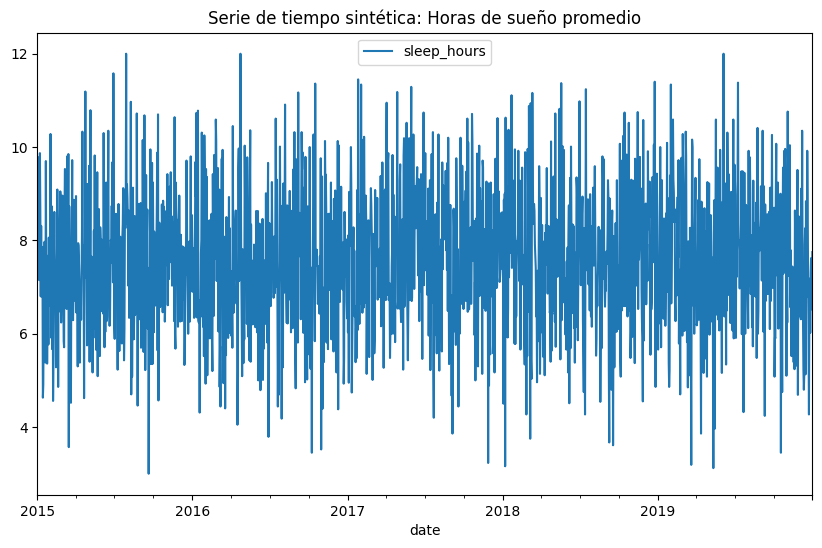

In [3]:
# Parámetros para la simulación
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_years = 5
days_per_year = 365
total_days = n_years * days_per_year

# Valores de la serie (en horas de sueño promedio diarias)
mean_sleep = 7.5  # Promedio de horas de sueño
std_sleep = 1.5   # Desviación estándar

# Generar datos con distribución normal
sleep_data = np.clip(
    np.random.normal(loc=mean_sleep, scale=std_sleep, size=total_days),
    a_min=3, a_max=12  # Limitar a rango [3, 12]
)

# Redondear los valores de heart_rate a 2 dígitos
sleep_data = np.round(sleep_data, 2)

# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")
synthetic_sleep_data = pd.DataFrame({"date": date_range, "sleep_hours": sleep_data})

synthetic_sleep_data["month"] = synthetic_sleep_data["date"].dt.to_period("M")

# Visualización inicial
print(synthetic_sleep_data.head())
synthetic_sleep_data.plot(x="date", y="sleep_hours", title="Serie de tiempo sintética: Horas de sueño promedio", figsize=(10, 6))


In [4]:
# Configurar el índice de fechas
synthetic_sleep_data['date'] = pd.to_datetime(synthetic_sleep_data['date'])
synthetic_sleep_data = synthetic_sleep_data.set_index('date')

In [5]:
# Procesamiento de la serie
scaler = StandardScaler()
sleep_scaled = scaler.fit_transform(synthetic_sleep_data[['sleep_hours']].values)

# Usar datos de 30 días para predecir el tiempo de sueño del día siguiente
sequence_length = 30  
sleep_data = synthetic_sleep_data["sleep_hours"].values  # Valores diarios de la serie

In [8]:
# Crear secuencias
def create_sequence(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Los últimos `seq_length` días
        Y.append(data[i+seq_length])   # El valor del siguiente día
    return np.array(X), np.array(Y)

In [9]:
# Crear las secuencias para sleep
X_sleep, Y_sleep = create_sequence(sleep_data, sequence_length)

# Agregar una nueva dimensión para convertir X en tridimensional (num_sequences, sequence_length, 1)
X_sleep = X_sleep[..., np.newaxis] 

# Verificar las formas de las secuencias
print(f"Shape de X (secuencias de entrada): {X_sleep.shape}")
print(f"Shape de Y (valores objetivo): {Y_sleep.shape}")

Shape de X (secuencias de entrada): (1795, 30, 1)
Shape de Y (valores objetivo): (1795,)


In [10]:
# División de datos en entrenamiento y validación
split = int(0.8 * len(X_sleep))
X_sleep_train, Y_sleep_train = X_sleep[:split], Y_sleep[:split]
X_sleep_val, Y_sleep_val = X_sleep[split:], Y_sleep[split:]

# Convertir a tensores
X_sleep_train = torch.tensor(X_sleep_train, dtype=torch.float32)
Y_sleep_train = torch.tensor(Y_sleep_train, dtype=torch.float32)
X_sleep_val = torch.tensor(X_sleep_val, dtype=torch.float32)
Y_sleep_val = torch.tensor(Y_sleep_val, dtype=torch.float32)

Entrenamiento Serie de tiempo de sueño

In [35]:
# Definir el modelo y parámetros de entrenamiento
input_dim = 1  # Serie de tiempo univariable (horas de sueño)
d_model = 64
nhead = 4
num_layers = 4
dropout = 0.3

model_sleep = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)

# Entrenamiento
num_epochs = 50
train_losses = []
val_losses = []

# Función de pérdica y optimizador
learning_rate = 0.005
weight_decay= 1e-4

criterion = nn.MSELoss()
optimizer = AdamW(model_sleep.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
    )

for epoch in range(num_epochs):  
    # Entrenamiento del modelo
    model_sleep.train()
    optimizer.zero_grad()
    outputs = model_sleep(X_sleep_train)
    loss = criterion(outputs.squeeze(), Y_sleep_train)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    # Validación
    model_sleep.eval()
    with torch.no_grad():
        outputs = model_sleep(X_sleep_val)
        val_loss = criterion(outputs.squeeze(), Y_sleep_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Scheduler: Reduce la tasa de aprendizaje en un factor (factor=0.5) si la pérdida de validación no mejora durante 5 épocas.
    scheduler.step(val_loss)
    
    # Early Stopping: Detiene el entrenamiento si la pérdida de validación no mejora
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1: Train Loss: 65.1487, Val Loss: 13.2354
Epoch 2: Train Loss: 16.8254, Val Loss: 9.5862
Epoch 3: Train Loss: 13.1871, Val Loss: 8.3565
Epoch 4: Train Loss: 11.9650, Val Loss: 7.2283
Epoch 5: Train Loss: 10.7081, Val Loss: 6.0700
Epoch 6: Train Loss: 9.4170, Val Loss: 5.0618
Epoch 7: Train Loss: 8.1749, Val Loss: 4.2057
Epoch 8: Train Loss: 6.9917, Val Loss: 3.4893
Epoch 9: Train Loss: 5.8950, Val Loss: 2.9385
Epoch 10: Train Loss: 4.8995, Val Loss: 2.5579
Epoch 11: Train Loss: 4.0124, Val Loss: 2.3278
Epoch 12: Train Loss: 3.3049, Val Loss: 2.2468
Epoch 13: Train Loss: 2.7757, Val Loss: 2.3142
Epoch 14: Train Loss: 2.3989, Val Loss: 2.5044
Epoch 15: Train Loss: 2.2393, Val Loss: 2.7749
Epoch 16: Train Loss: 2.2323, Val Loss: 3.0735
Epoch 17: Train Loss: 2.3146, Val Loss: 3.3210
Epoch 18: Train Loss: 2.4053, Val Loss: 3.4152
Epoch 19: Train Loss: 2.4710, Val Loss: 3.3448
Epoch 20: Train Loss: 2.4485, Val Loss: 3.1641
Epoch 21: Train Loss: 2.3844, Val Loss: 2.8978
Epoch 22: Train 

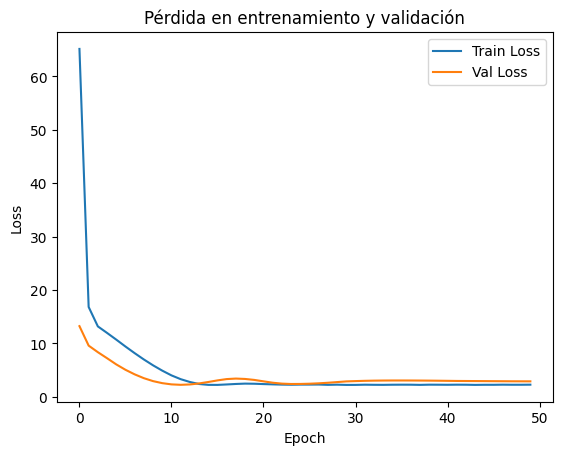

In [36]:
# Graficar pérdidas

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()

Serie de tiempo sintética sobre frecuencia cardíaca.

        date  heart_rate    month
0 2015-01-01       74.97  2015-01
1 2015-01-02       68.62  2015-01
2 2015-01-03       76.48  2015-01
3 2015-01-04       85.23  2015-01
4 2015-01-05       67.66  2015-01


<Axes: title={'center': 'Serie de tiempo sintética: Frecuencia cardíaca promedio'}, xlabel='date'>

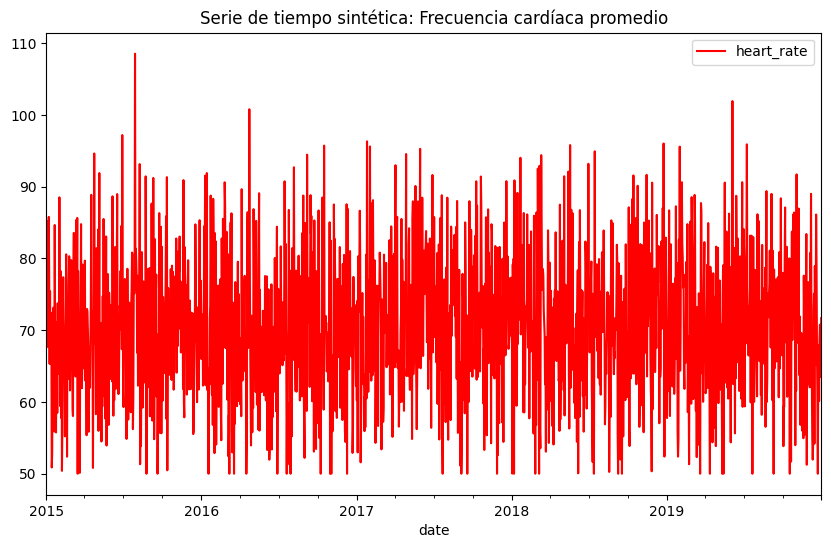

In [11]:
# Parámetros para la simulación
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_years = 5
days_per_year = 365
total_days = n_years * days_per_year

# Valores de la serie (frecuencia cardíaca promedio diaria en latidos por minuto)
mean_hr = 70  # Promedio de frecuencia cardíaca
std_hr = 10   # Desviación estándar

# Generar datos con distribución normal
heart_rate_data = np.clip(
    np.random.normal(loc=mean_hr, scale=std_hr, size=total_days),
    a_min=50, a_max=120  # Limitar a rango [50, 120]
)

# Redondear los valores de heart_rate a 2 dígitos
heart_rate_data = np.round(heart_rate_data, 2)

# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")
synthetic_hr_data = pd.DataFrame({"date": date_range, "heart_rate": heart_rate_data})

synthetic_hr_data["month"] = synthetic_hr_data["date"].dt.to_period("M")

# Visualización inicial
print(synthetic_hr_data.head())
synthetic_hr_data.plot(x="date", y="heart_rate", title="Serie de tiempo sintética: Frecuencia cardíaca promedio", figsize=(10, 6), color='red')

In [12]:
# Configurar el índice de fechas
synthetic_hr_data['date'] = pd.to_datetime(synthetic_hr_data['date'])
synthetic_hr_data = synthetic_hr_data.set_index('date')

In [13]:
# Procesamiento de la serie
scaler = StandardScaler()
hr_scaled = scaler.fit_transform(synthetic_hr_data[['heart_rate']].values)

In [14]:
# Preparación de datos para entrenamiento
sequence_length = 30  # Usar datos de un mes para predecir el siguiente día

# Crear las secuencias usando los valores diarios
hr_data = synthetic_hr_data["heart_rate"].values  # Valores diarios de la serie
X_hr, Y_hr = create_sequence(hr_data, sequence_length)

# Agregar una nueva dimensión para convertir X en tridimensional (num_sequences, sequence_length, 1)
X_hr = X_hr[..., np.newaxis]

# Verificar las formas de las secuencias
print(f"Shape de X_hr (secuencias de entrada): {X_hr.shape}")
print(f"Shape de Y_hr (valores objetivo): {Y_hr.shape}")

Shape de X_hr (secuencias de entrada): (1795, 30, 1)
Shape de Y_hr (valores objetivo): (1795,)


In [15]:
# División de datos en entrenamiento y validación
split = int(0.8 * len(X_hr))
X_hr_train, Y_hr_train = X_hr[:split], Y_hr[:split]
X_hr_val, Y_hr_val = X_hr[split:], Y_hr[split:]

# Convertir a tensores
X_hr_train = torch.tensor(X_hr_train, dtype=torch.float32)
Y_hr_train = torch.tensor(Y_hr_train, dtype=torch.float32)
X_hr_val = torch.tensor(X_hr_val, dtype=torch.float32)
Y_hr_val = torch.tensor(Y_hr_val, dtype=torch.float32)

Entrenamiento Serie de tiempo de frecuencia cardíaca promedio diaria

In [16]:
import torch.nn.init as init

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):  # Verifica si la capa tiene parámetros
            layer.reset_parameters()

In [38]:
# Definir el modelo y parámetros de entrenamiento
input_dim = 1  # Serie de tiempo univariable (frecuencia cardíaca)
d_model = 128
nhead = 8
num_layers = 8
dropout = 0.3

model_hr = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)
reset_weights(model_hr)

# Entrenamiento
num_epochs = 120
train_losses = []
val_losses = []

# Función de pérdica y optimizador
learning_rate = 0.005
weight_decay= 1e-6

criterion = nn.MSELoss()
optimizer = AdamW(model_hr.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
    )

for epoch in range(num_epochs):  
    # Entrenamiento del modelo
    model_hr.train()
    optimizer.zero_grad()
    outputs = model_hr(X_hr_train)
    loss = criterion(outputs.squeeze(), Y_hr_train)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    # Validación
    model_hr.eval()
    with torch.no_grad():
        outputs = model_hr(X_hr_val)
        val_loss = criterion(outputs.squeeze(), Y_hr_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Scheduler: Reduce la tasa de aprendizaje en un factor (factor=0.5) si la pérdida de validación no mejora durante 5 épocas.
    scheduler.step(val_loss)
    
    # Early Stopping: Detiene el entrenamiento si la pérdida de validación no mejora
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1: Train Loss: 5065.5981, Val Loss: 4281.3052
Epoch 2: Train Loss: 4369.2993, Val Loss: 4139.9282
Epoch 3: Train Loss: 4248.7500, Val Loss: 4083.4778
Epoch 4: Train Loss: 4193.3350, Val Loss: 4007.2200
Epoch 5: Train Loss: 4126.7280, Val Loss: 3932.8650
Epoch 6: Train Loss: 4059.1477, Val Loss: 3860.0410
Epoch 7: Train Loss: 3978.4976, Val Loss: 3793.1836
Epoch 8: Train Loss: 3889.5547, Val Loss: 3716.4209
Epoch 9: Train Loss: 3801.7988, Val Loss: 3637.5874
Epoch 10: Train Loss: 3726.7026, Val Loss: 3550.4199
Epoch 11: Train Loss: 3646.6841, Val Loss: 3460.9053
Epoch 12: Train Loss: 3560.3406, Val Loss: 3377.9785
Epoch 13: Train Loss: 3479.4888, Val Loss: 3293.4602
Epoch 14: Train Loss: 3396.1804, Val Loss: 3205.1030
Epoch 15: Train Loss: 3306.7642, Val Loss: 3116.5498
Epoch 16: Train Loss: 3217.7405, Val Loss: 3027.8491
Epoch 17: Train Loss: 3130.1440, Val Loss: 2937.4819
Epoch 18: Train Loss: 3043.5825, Val Loss: 2847.4612
Epoch 19: Train Loss: 2954.4998, Val Loss: 2757.6340
Ep

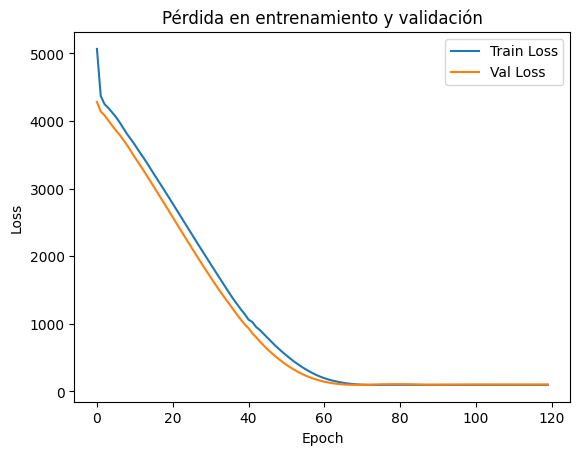

In [39]:
# Graficar pérdidas

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()

Multivariate training

In [17]:
# Crear un DataFrame con ambas series
data = pd.DataFrame({
    'Sleep Hours': sleep_data,
    'Heart Rate': hr_data
})
print(data.head())

   Sleep Hours  Heart Rate
0         8.25       74.97
1         7.29       68.62
2         8.47       76.48
3         9.78       85.23
4         7.15       67.66


        date  sleep_hours  heart_rate
0 2015-01-01         8.25       74.97
1 2015-01-02         7.29       68.62
2 2015-01-03         8.47       76.48
3 2015-01-04         9.78       85.23
4 2015-01-05         7.15       67.66


<Axes: title={'center': 'Serie de tiempo sintética: Horas de sueño y frecuencia cardíaca promedio'}, xlabel='date'>

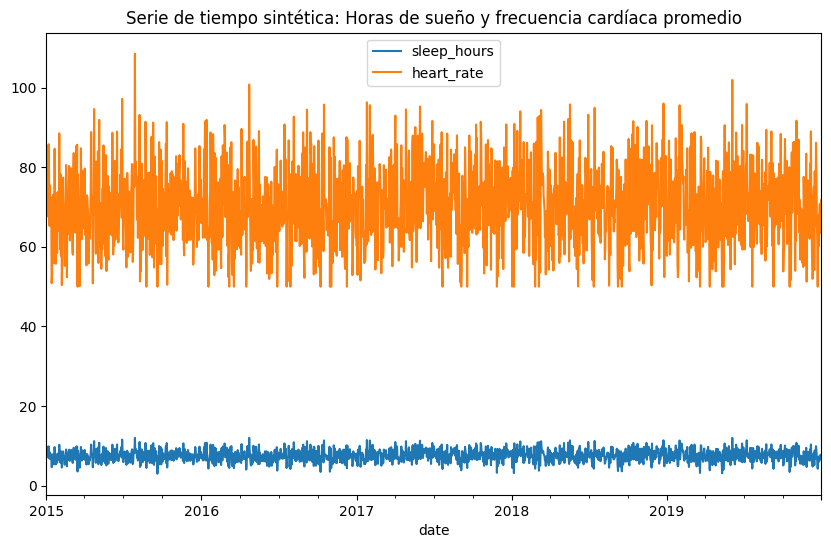

In [18]:
# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")
synthetic_data = pd.DataFrame({"date": date_range, "sleep_hours": data["Sleep Hours"], "heart_rate": data["Heart Rate"]})

# Visualización inicial
print(synthetic_data.head())
synthetic_data.plot(x="date", y=["sleep_hours", "heart_rate"], title="Serie de tiempo sintética: Horas de sueño y frecuencia cardíaca promedio", figsize=(10, 6))

In [19]:
def create_sequences_multivariate(data1, data2, seq_length):
    X, Y = [], []
    for i in range(len(data1) - seq_length):
        # Concatenar ambas series
        X.append(np.stack((data1[i:i+seq_length], data2[i:i+seq_length]), axis=1))
        Y.append(data1[i+seq_length])  # Objetivo: predicción basada en la primera serie
    return np.array(X), np.array(Y)

In [20]:
scaler_sleep = StandardScaler()
scaler_heart = StandardScaler()

sleep_scaled = scaler_sleep.fit_transform(sleep_data.reshape(-1, 1))
hr_scaled = scaler_heart.fit_transform(hr_data.reshape(-1, 1))

In [21]:
# Usar datos de 30 días de horas de sueño y frecuencia cardíaca promedio para predecir el tiempo de sueño del día siguiente
X, Y = create_sequences_multivariate(sleep_scaled, hr_scaled, sequence_length)

# Eliminar la dimensión extra del tensor X
X = X.squeeze(-1)  # Nueva forma: (1795, 30, 2)

print("Forma de X:", X.shape)  # (n_secuencias, sequence_length, n_features)
print("Forma de Y:", Y.shape)  # (n_secuencias, n_targets)

Forma de X: (1795, 30, 2)
Forma de Y: (1795, 1)


In [22]:
# Dividir en conjuntos de entrenamiento y prueba
split = int(0.8 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_val, Y_val = X[split:], Y[split:]

# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

In [27]:
# Clase para predecir un valor escalar a partir de una secuencia de datos multivariado. 

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, sequence_length):
        super(TimeSeriesTransformer, self).__init__()
        
        # Parámetros
        self.input_dim = input_dim  # Dimensión de entrada (número de características)
        self.d_model = d_model
        self.sequence_length = sequence_length

        # Embedding lineal para mapear múltiples características al espacio de d_model
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, sequence_length, d_model)
        )
        
        # Transformer Encoder con batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout, 
            batch_first=True  # Asegura que las entradas sean en formato (batch_size, seq_len, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decodificador lineal para producir la predicción
        self.decoder = nn.Linear(d_model, 1)  # Salida de un único valor (horas de sueño)

    def forward(self, x):
        """
        x: Tensor con forma (batch_size, sequence_length, input_dim)
        """
        # Embedding de la entrada
        x = self.embedding(x)  # Salida: (batch_size, sequence_length, d_model)
        
        # Agregar codificación posicional
        if self.positional_encoding.size(1) >= x.size(1):  # Asegurar que las dimensiones coincidan
            x += self.positional_encoding[:, :x.size(1), :]
        else:
            raise ValueError("La longitud de secuencia es mayor que el tamaño de codificación posicional.")
        
        # Transformar la entrada con el encoder del Transformer
        x = self.transformer_encoder(x)  # Salida: (batch_size, sequence_length, d_model)
        
        # Extraer la salida correspondiente al último paso temporal
        x = x[:, -1, :]  # Último paso: (batch_size, d_model)
        
        # Decodificar para generar la predicción
        return self.decoder(x)

In [ ]:
# Parámetros del modelo y entrenamiento
input_dim = 2  # Dos características: horas de sueño y frecuencia cardíaca
d_model = 512
nhead = 12
num_layers = 8
dropout = 0.3
sequence_length = 30

# Creación del modelo
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)

# Variables del entrenamiento
num_epochs = 150
train_losses = []
val_losses = []

# Función de pérdida y optimizador
learning_rate = 0.005
weight_decay = 1e-4

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Ciclo de entrenamiento
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    for i in range(X_train.shape[0]):
        X_batch = X_train[i:i+1].clone().detach().float()  # Asegurar la dimensión (1, 30, 2)
        Y_batch = Y_train[i:i+1].clone().detach().float().unsqueeze(-1)  # Asegurar la dimensión (1, 1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(X_val.shape[0]):
            X_batch = X_val[i:i+1].clone().detach().float()  # Asegurar la dimensión (1, 30, 2)
            Y_batch = Y_val[i:i+1].clone().detach().float().unsqueeze(-1)  # Asegurar la dimensión (1, 1)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()
    
    # Registrar pérdidas promedio
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Scheduler
    scheduler.step(val_losses[-1])
    
    # Early Stopping
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

    # Imprimir progreso
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Resultados finales
print("Entrenamiento completado.")
print(f"Mejor pérdida de validación: {best_val_loss:.4f}")

/tmp/ipykernel_239237/158626710.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_train[i:i+1], dtype=torch.float32)  # Asegurar la dimensión (1, 30, 2)
/tmp/ipykernel_239237/158626710.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_batch = torch.tensor(Y_train[i:i+1], dtype=torch.float32).unsqueeze(-1)  # Asegurar la dimensión (1, 1)
/tmp/ipykernel_239237/158626710.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_val[i:i+1], dtype=torch.float32)  # Dimensión (1, 30, 2)
/tmp/

Epoch 1/150 - Train Loss: 1801.4157, Val Loss: 419.8118
Epoch 2/150 - Train Loss: 1519.6890, Val Loss: 435.0767
Epoch 3/150 - Train Loss: 1512.8510, Val Loss: 391.3411
Epoch 4/150 - Train Loss: 1508.2799, Val Loss: 394.9590
Epoch 5/150 - Train Loss: 1501.3035, Val Loss: 390.8881
Epoch 6/150 - Train Loss: 1485.5660, Val Loss: 386.9376
Epoch 7/150 - Train Loss: 1473.1302, Val Loss: 381.3745
Epoch 8/150 - Train Loss: 1475.1322, Val Loss: 390.4280
Epoch 9/150 - Train Loss: 1464.0130, Val Loss: 398.4029
Epoch 10/150 - Train Loss: 1474.4313, Val Loss: 385.9622
Epoch 11/150 - Train Loss: 1465.2261, Val Loss: 389.2396
Epoch 12/150 - Train Loss: 1463.9105, Val Loss: 380.3592
Epoch 13/150 - Train Loss: 1466.9245, Val Loss: 387.9355
Epoch 14/150 - Train Loss: 1476.4014, Val Loss: 391.0730
Epoch 15/150 - Train Loss: 1484.8152, Val Loss: 391.5653
Epoch 16/150 - Train Loss: 1475.6952, Val Loss: 389.1873
Epoch 17/150 - Train Loss: 1483.7284, Val Loss: 383.8474
Epoch 18/150 - Train Loss: 1477.6301, Va

KeyboardInterrupt: 

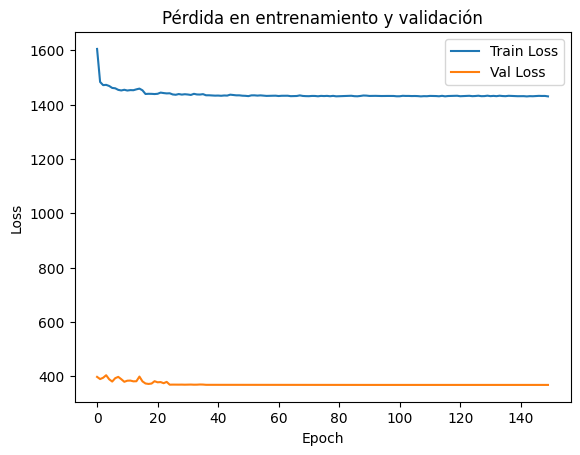

In [29]:
# Graficar pérdidas

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()